## T2 (By Bhavya)

In [1]:
import re
import numpy as np
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
t2_data = pd.read_csv(r'PHY_451_T2_data/FeM5.00e-03.csv')
t2_data

,# CH1 D2.1843e-03,CH2 D2.1843e-03,CH4 D2.1843e-03,CH1 D6.0571e-04,CH2 D6.0571e-04,CH4 D6.0571e-04,CH1 D1.7107e-03,CH2 D1.7107e-03,CH4 D1.7107e-03,CH1 D2.5000e-03,...,CH1 D2.3421e-03,CH2 D2.3421e-03,CH4 D2.3421e-03,CH1 D9.2143e-04,CH2 D9.2143e-04,CH4 D9.2143e-04,CH1 D1.2371e-03,CH2 D1.2371e-03,CH4 D1.2371e-03,
0,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,...,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,NaN
1,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,...,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,NaN
2,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,...,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,NaN
3,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,...,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,NaN
4,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,...,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10003,-0.00512,-0.00512,-0.00484,-0.00512,-0.00512,-0.00488,-0.00512,-0.00512,-0.00504,-0.00512,...,-0.00512,-0.00512,-0.00472,-0.00512,-0.00512,-0.00496,-0.00508,-0.00512,-0.00520,NaN
10004,-0.00512,-0.00512,-0.00496,-0.00512,-0.00512,-0.00492,-0.00512,-0.00512,-0.00504,-0.00512,...,-0.00512,-0.00512,-0.00480,-0.00512,-0.00512,-0.00496,-0.00508,-0.00512,-0.00516,NaN
10005,-0.00512,-0.00508,-0.00484,-0.00512,-0.00512,-0.00504,-0.00508,-0.00512,-0.00496,-0.00512,...,-0.00512,-0.00512,-0.00480,-0.00512,-0.00512,-0.00488,-0.00512,-0.00512,-0.00500,NaN
10006,-0.00512,-0.00512,-0.00484,-0.00512,-0.00512,-0.00492,-0.00512,-0.00512,-0.00500,-0.00512,...,-0.00512,-0.00512,-0.00480,-0.00508,-0.00512,-0.00480,-0.00512,-0.00512,-0.00492,NaN


# Example (Skip)

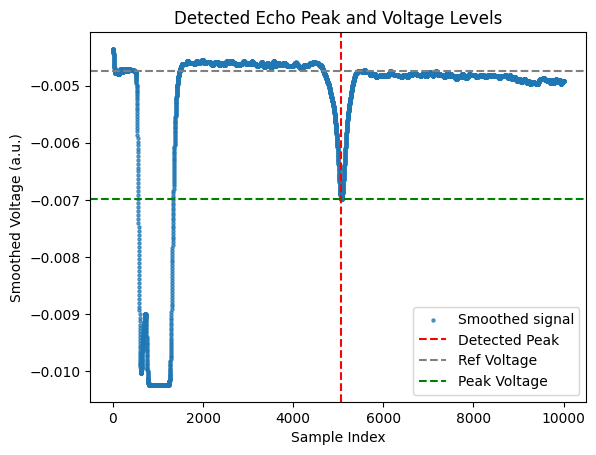

In [3]:
# Extract channel data
ch4 = t2_data.iloc[:, 2 * 3 + 2]
times = np.arange(ch4.shape[0])

# Smooth the signal
smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
drange = np.max(smoothed) - np.min(smoothed)

# Define search range
filter = smoothed.shape[0] - np.argmin(smoothed[::-1])

# --- same adaptive prominence search logic from get_voltage_diff() ---
min_prom = drange * 0.001
max_prom = drange * 0.8

for i in range(100):
    prominance = (min_prom, max_prom)
    peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)

    if len(peaks) == 1:
        break
    elif len(peaks) > 1:
        min_prom = min_prom + (max_prom - min_prom) * 0.1
    else:
        min_prom = min_prom * 0.5

    if min_prom >= max_prom:
        raise ValueError("Cannot find exactly 1 peak with valid prominence range")
else:
    print("Warning: Failed to find exactly 1 peak after maximum iterations")
    peaks = []

# --- Plot the signal ---
plt.scatter(times, smoothed, s=5, alpha=0.7, label='Smoothed signal')

# Plot the single detected peak (if found)
if len(peaks) == 1:
    echo_peak_idx = peaks[0] + filter
    plt.axvline(echo_peak_idx, color='r', linestyle='--', label='Detected Peak')

# Reference and peak voltage lines (for context)
ref_voltage = np.percentile(smoothed, 65)
plt.axhline(ref_voltage, color='gray', linestyle='--', label='Ref Voltage')

if len(peaks) == 1:
    peak_voltage = smoothed[echo_peak_idx]
    plt.axhline(peak_voltage, color='green', linestyle='--', label='Peak Voltage')

plt.title("Detected Echo Peak and Voltage Levels")
plt.xlabel("Sample Index")
plt.ylabel("Smoothed Voltage (a.u.)")
plt.legend()
plt.show()

# Calculating T2 (Real Stuff)

In [ ]:
def find_delta_t(ch2, ch4_signal: np.ndarray) -> int:
    # Calculate peak of echo
    smoothed = scipy.ndimage.gaussian_filter(ch4_signal, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # Iteratively adjust prominence to find exactly 1 peak
    min_prom = drange * 0.02
    max_prom = drange * 0.8
    
    for i in range(100):  # Max iterations to prevent infinite loop
        prominance = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)
        
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            # Too many peaks, increase lower bound
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            # No peaks found, decrease lower bound
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return np.nan
    
    echo_peak_idx = peaks[0]

    # Find falling edge of pulse
    ch2 = np.asarray(ch2)
    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1]

    return echo_peak_idx - filter_idx

def get_voltage_diff(ch4) -> float:
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # Iteratively adjust prominence to find exactly 1 peak
    min_prom = drange * 0.001
    max_prom = drange * 0.8
    
    for i in range(100):  # Max iterations to prevent infinite loop
        prominance = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)
        
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            # Too many peaks, increase lower bound
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            # No peaks found, decrease lower bound
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return np.nan
    echo_peak_idx = peaks[0]

    ref_voltage = np.percentile(smoothed, 65)
    peak_voltage = smoothed[echo_peak_idx + filter]

    return peak_voltage - ref_voltage

def extract_delta_times(df):
    """
    Extract delta times from column labels that contain 'D' followed by scientific notation.
    Returns a list of delta times corresponding to each column.
    """
    delta_times = []
    
    for col in df.columns:
        # Search for 'D' followed by scientific notation (e.g., D1.5e-3, D2.5E+2)
        match = re.search(r'D([-+]?\d+\.?\d*[eE][-+]?\d+)', str(col))
        if match:
            delta_time = float(match.group(1))
            delta_times.append(delta_time)
        else:
            delta_times.append(None)  # No match found
    
    return np.asarray(delta_times)

def get_unique_delta_times(df):
    """
    Get unique delta times from columns (accounting for triplet pattern).
    Returns unique delta times in order of appearance.
    """
    delta_times = extract_delta_times(df)
    unique_times = []
    seen = set()
    
    for dt in delta_times:
        if dt is not None and dt not in seen:
            unique_times.append(dt)
            seen.add(dt)
    
    return np.asarray(unique_times)

In [14]:
def plot_peak_for_delay(ch2, ch4, dt_label, time_scale=1e-6):
    """
    Plot CH4 signal with detected echo peak and CH2 falling edge.
    """
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    # Re-run your peak-finding steps
    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # find peak
    min_prom = drange * 0.02
    max_prom = drange * 0.8
    for _ in range(100):
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=(min_prom, max_prom))
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom += (max_prom - min_prom) * 0.1
        else:
            min_prom *= 0.5
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak.")
    
    echo_peak_idx = peaks[0] + filter_start

    # find falling edge
    ch2 = np.asarray(ch2)
    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1]
    filter_idx = int(filter_idx)

    delta_idx = echo_peak_idx - filter_idx
    delta_time = delta_idx * time_scale

    # --- Plot ---
    plt.figure(figsize=(10,5))
    
    plt.plot(smoothed, label="Smoothed CH4 signal", color='black')
    plt.axvline(echo_peak_idx, color='red', linestyle='--', label=f"Echo peak = {echo_peak_idx}")
    plt.axvline(filter_idx, color='blue', linestyle='--', label=f"Falling edge = {filter_idx}")
    
    plt.title(f"Peak Finding for Delay D={dt_label} s  |  Δt = {delta_time:.6f} s")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage (arb. units)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plotting delay 0.0010793 seconds


C:\Users\volca\AppData\Local\Temp\ipykernel_13876\3964840496.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_idx = int(filter_idx)


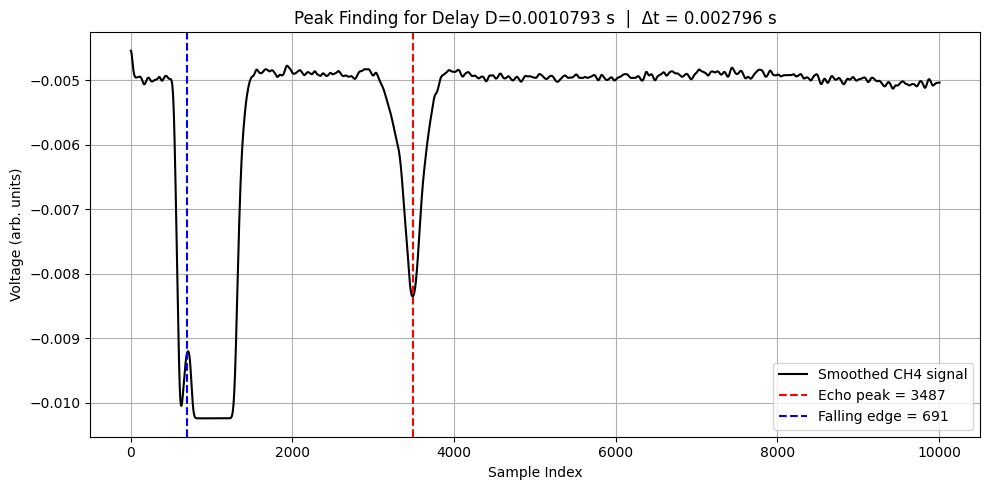

Plotting delay 0.00076357 seconds


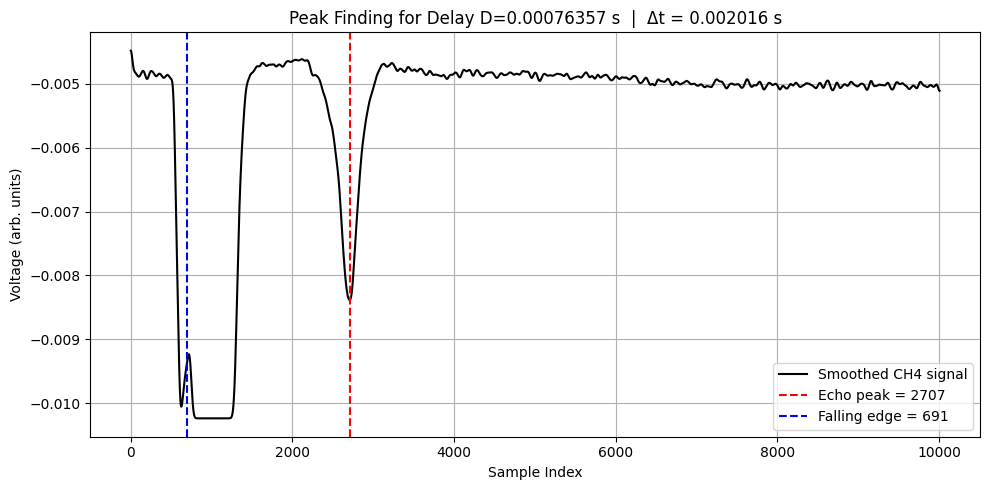

Plotting delay 0.0017107 seconds


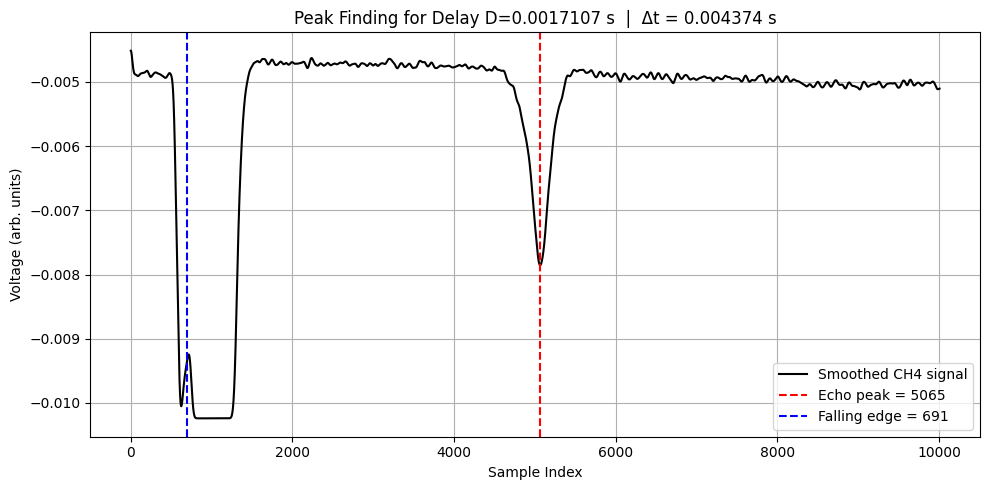

Plotting delay 0.00029 seconds


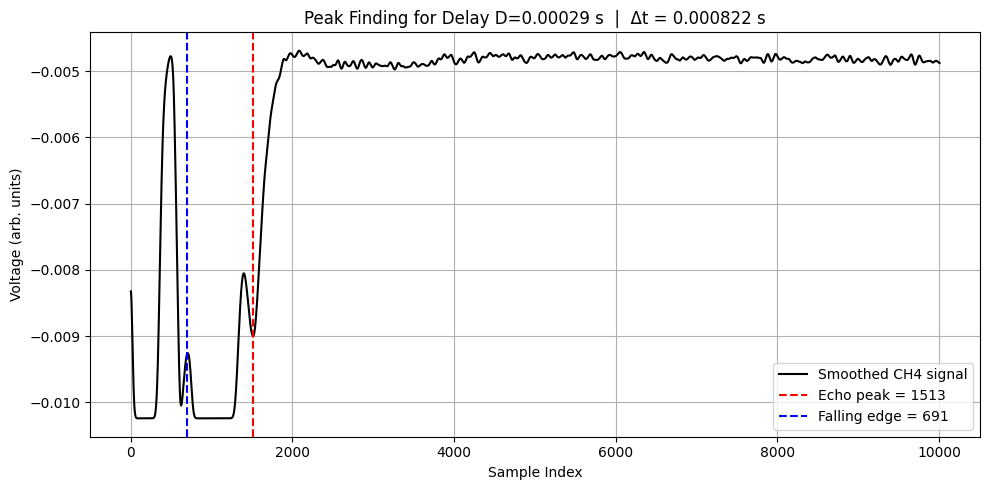

Plotting delay 0.00060571 seconds


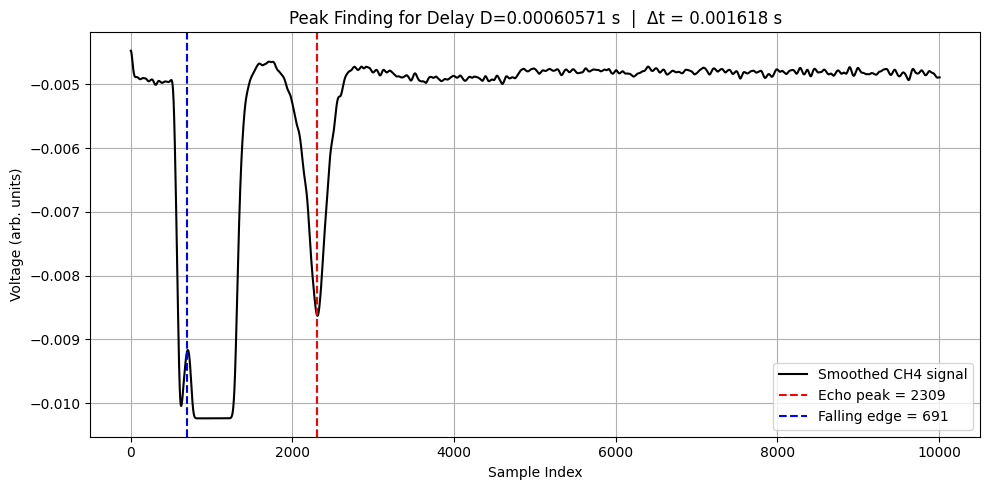

Plotting delay 0.0025 seconds


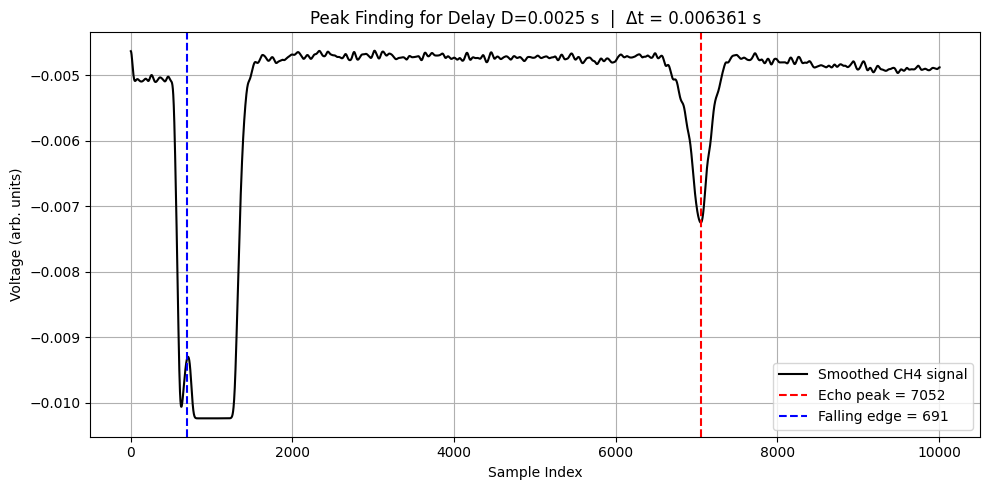

Plotting delay 0.0021843 seconds


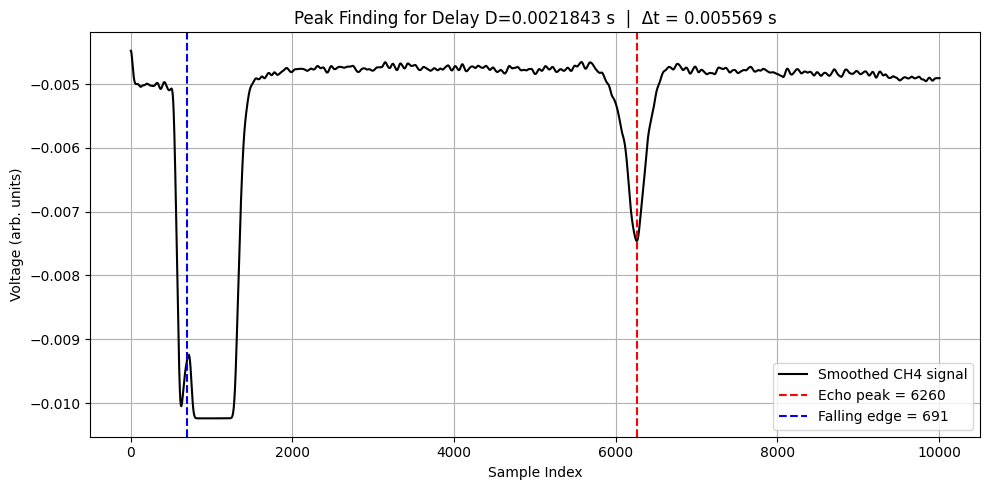

Plotting delay 0.0020264 seconds


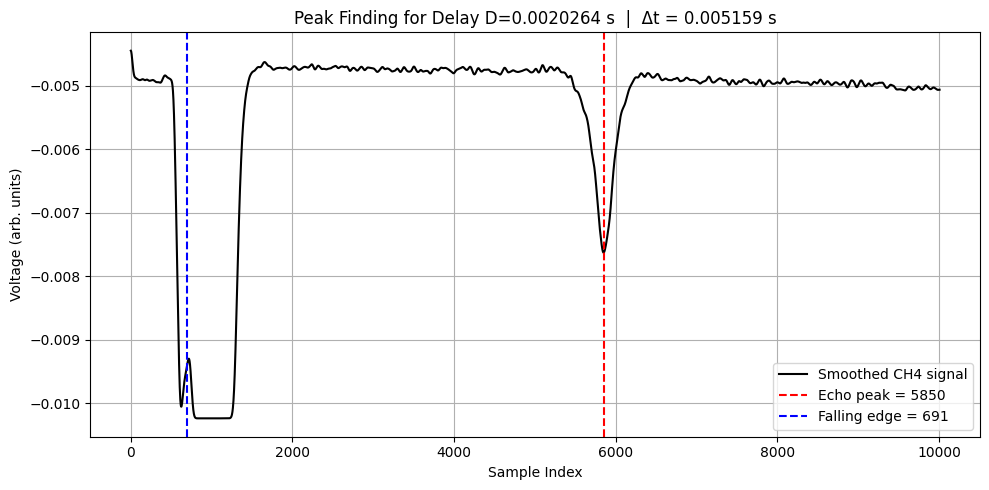

Plotting delay 0.0018686 seconds


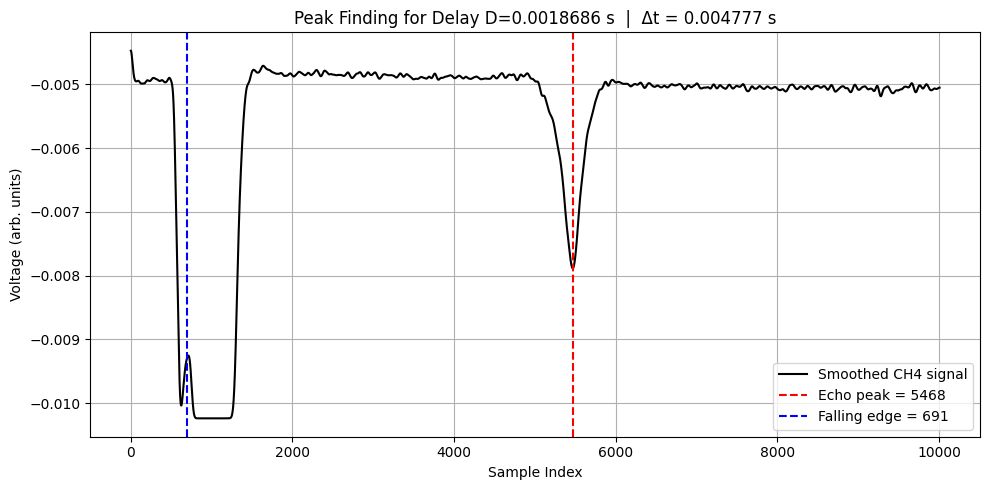

Plotting delay 0.00044786 seconds


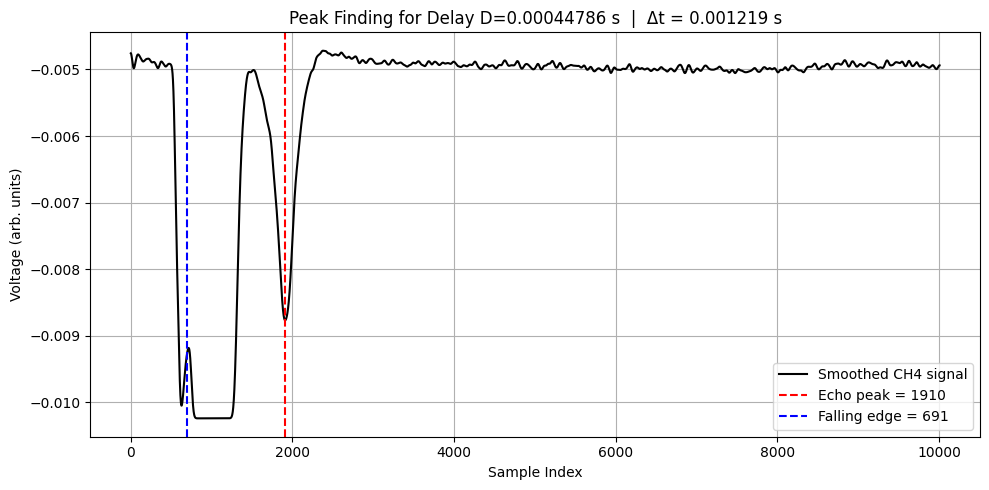

Plotting delay 0.0015529 seconds


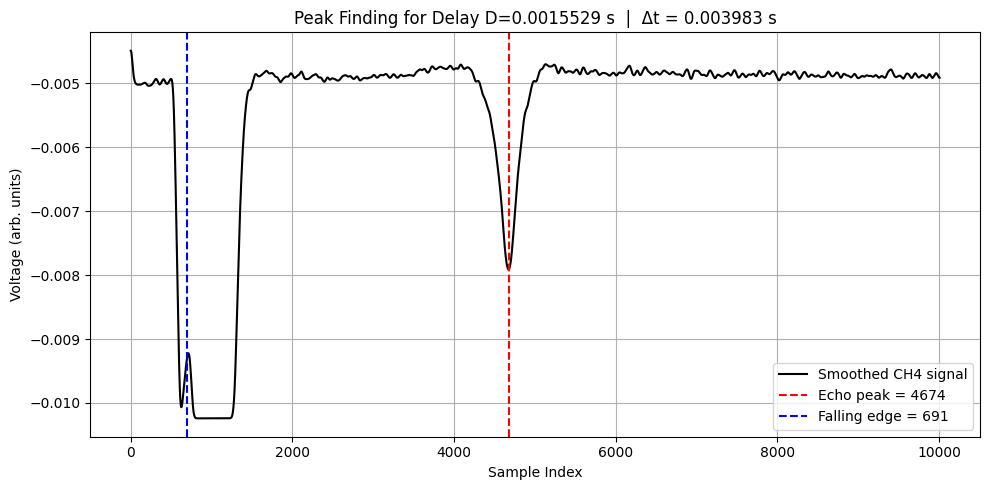

Plotting delay 0.0023421 seconds


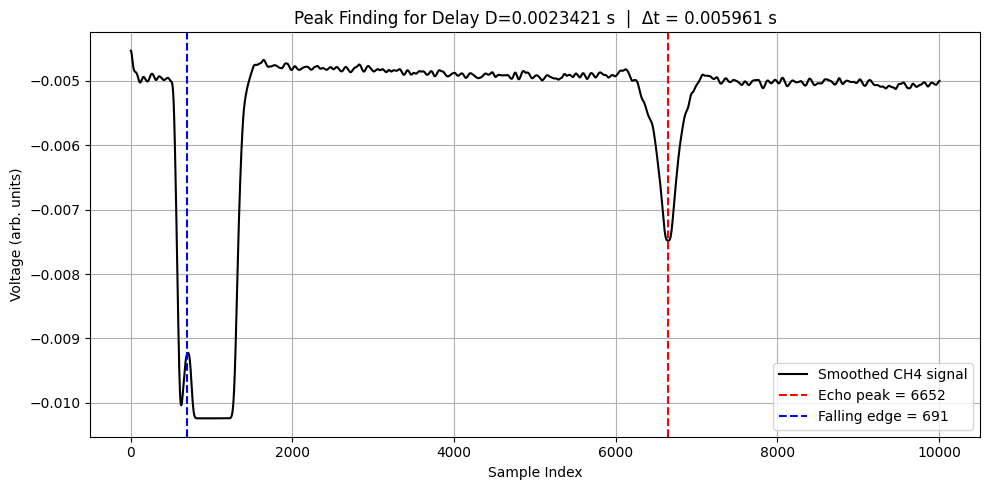

Plotting delay 0.0012371 seconds


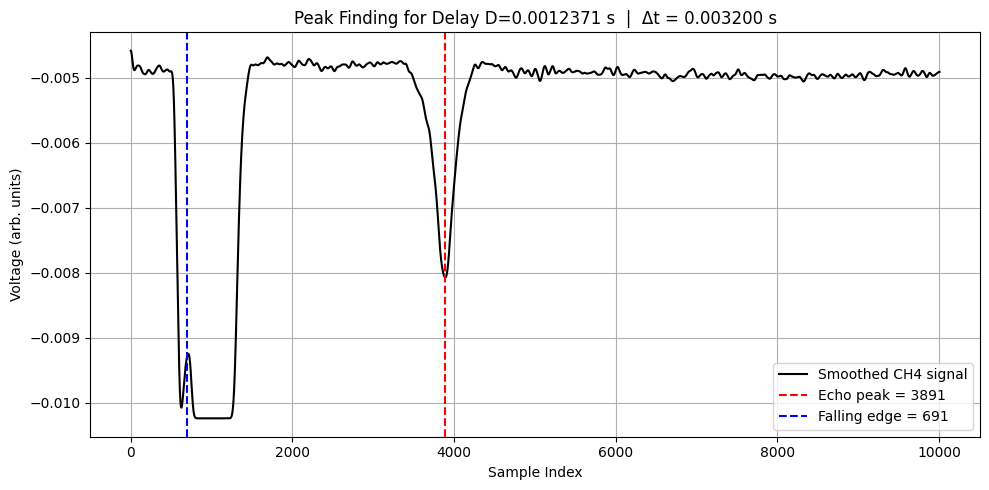

Plotting delay 0.00092143 seconds


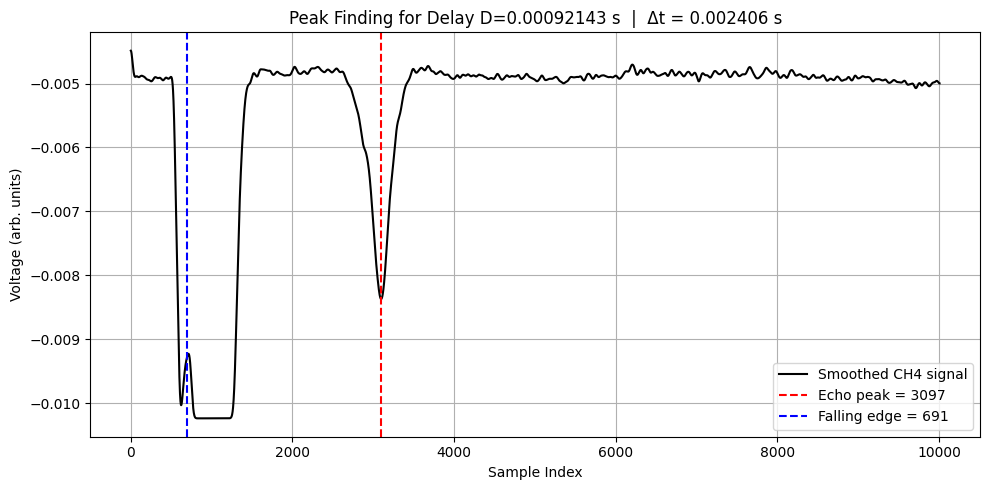

Plotting delay 0.001395 seconds


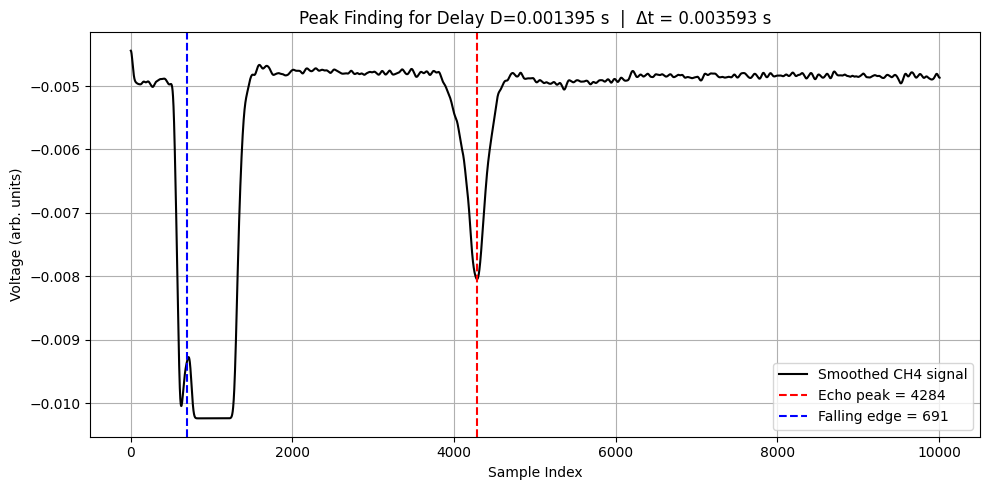

In [15]:
combined_df = pd.read_csv(r'PHY_451_T2_data/CuM1.00e-01.csv')
unique_delays = get_unique_delta_times(combined_df)

time_trial_count = len(combined_df.columns) // 3

for i in range(time_trial_count):
    dt_label = unique_delays[i]
    ch2 = combined_df.iloc[:, 3*i + 1]
    ch4 = combined_df.iloc[:, 3*i + 2]

    print(f"Plotting delay {dt_label} seconds")
    plot_peak_for_delay(ch2, ch4, dt_label)


In [7]:
def find_delta_t(ch2, ch4_signal: np.ndarray):
    smoothed = scipy.ndimage.gaussian_filter(ch4_signal, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])
    min_prom = drange * 0.02
    max_prom = drange * 0.8
    
    for _ in range(100):
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=(min_prom, max_prom))
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom += (max_prom - min_prom) * 0.1
        else:
            min_prom *= 0.5
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak.")
    else:
        return np.nan
    
    echo_peak_idx = peaks[0]

    ch2 = np.asarray(ch2)
    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1]

    return echo_peak_idx - filter_idx


def get_voltage_diff(ch4):
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)

    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])
    min_prom = drange * 0.001
    max_prom = drange * 0.8

    for _ in range(100):
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=(min_prom, max_prom))
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom += (max_prom - min_prom) * 0.1
        else:
            min_prom *= 0.5
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak.")
    else:
        return np.nan

    echo_peak_idx = peaks[0]
    ref_voltage = np.percentile(smoothed, 65)
    peak_voltage = smoothed[echo_peak_idx + filter_start]

    return peak_voltage - ref_voltage


def extract_delta_times(df):
    delta_times = []
    for col in df.columns:
        match = re.search(r'D([-+]?\d+\.?\d*[eE][-+]?\d+)', str(col))
        if match:
            delta_times.append(float(match.group(1)))
        else:
            delta_times.append(None)
    return np.asarray(delta_times)


def get_unique_delta_times(df):
    delta_times = extract_delta_times(df)
    unique_times = []
    seen = set()
    for dt in delta_times:
        if dt is not None and dt not in seen:
            unique_times.append(dt)
            seen.add(dt)
    return np.asarray(unique_times)


# -----------------------------------------------------------
#  NEW FUNCTION (with updated error calculations)
# -----------------------------------------------------------

def build_t2_arrays(df):
    """
    Returns:
      unique_delays      : programmed delays (from column names)
      delta_t            : 2× delay time (in seconds)
      delta_t_err        : sqrt(2)*0.001 ms (converted to seconds)
      amplitudes         : peak amplitudes
      amp_err            : noise from last 200 bins of smoothed trace
    """

    unique_delays = get_unique_delta_times(df)
    time_trial_count = len(df.columns) // 3

    # ---- Δt = 2 × delay ----
    delta_t = 2 * unique_delays  # seconds

    # ---- Δt uncertainty = sqrt(2)*0.001 ms ----
    delta_t_err = np.full_like(delta_t, np.sqrt(2) * 1e-6)  # convert ms→s

    # ---- amplitude and its uncertainty ----
    amplitudes = []
    amp_err = []

    for i in range(time_trial_count):
        ch4 = df.iloc[:, 3*i + 2]
        
        # amplitude
        amp = get_voltage_diff(ch4)

        # noise = stddev of last 200 samples of smoothed trace
        smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
        noise = np.std(ch4[-200:])

        amplitudes.append(amp)
        amp_err.append(noise)

    return (
        unique_delays,
        delta_t,
        delta_t_err,
        np.asarray(amplitudes),
        np.asarray(amp_err)
    )


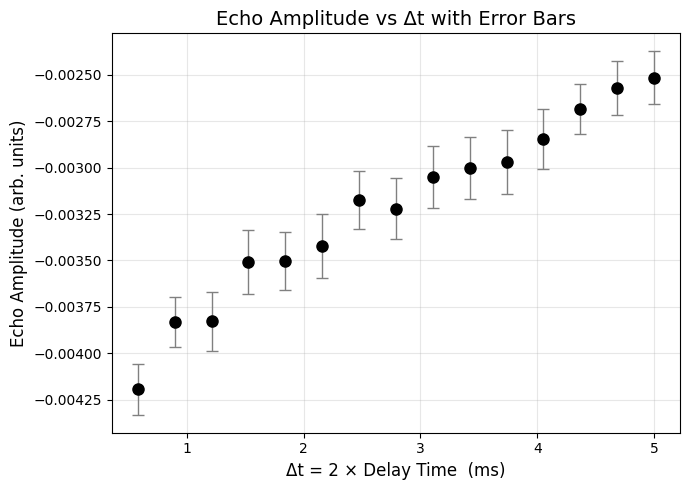

In [8]:
unique_delays, delta_t, delta_t_err, amplitudes, amp_err = build_t2_arrays(combined_df)

plt.figure(figsize=(7,5))

plt.errorbar(
    delta_t * 1e3,              # convert Δt to ms
    amplitudes,
    xerr=delta_t_err * 1e3,     # convert Δt error to ms
    yerr=amp_err,
    fmt='o',
    markersize=8,
    capsize=4,
    ecolor='gray',
    elinewidth=1,
    color='black'
)

plt.xlabel("Δt = 2 × Delay Time  (ms)", fontsize=12)
plt.ylabel("Echo Amplitude (arb. units)", fontsize=12)
plt.title("Echo Amplitude vs Δt with Error Bars", fontsize=14)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
def get_times_t2(data):
    
    time_trial_count = len(data.columns)//3
    time_data = np.empty((time_trial_count, 3))
    #### VERIFY DUMBASS
    # TODO: Check Time scale
    # Todo: Update both getimes methods approriately
    time_scale = 0.0001
    
    times = get_unique_delta_times(data)

    for i in range(time_trial_count):
        ch1 = data.iloc[:, 3*i + 0]
        ch2 = data.iloc[:, 3*i + 1]
        ch4 = data.iloc[:, 3*i + 2]

        dt_idx = find_delta_t(ch2, ch4)
        delta_t = dt_idx * time_scale

        voltage = get_voltage_diff(ch4)

        time_data[i, 0] = times[i]
        time_data[i, 1] = delta_t
        time_data[i, 2] = voltage
    
    return time_data

In [10]:
def exp_func(x, a, b):
    return a * np.exp(-b * x)


def find_t2(pd_data: pd.DataFrame, plot: bool = False):
    # ---------------------------------------------------
    # Use your updated pipeline for Δt, amplitude, errors
    # ---------------------------------------------------
    unique_delays, delta_t, delta_t_err, amplitudes, amp_err = build_t2_arrays(pd_data)

    # Remove NaNs
    mask = ~np.isnan(delta_t) & ~np.isnan(amplitudes)
    x = delta_t[mask]
    y = amplitudes[mask]
    yerr = amp_err[mask]

    # -------------------------------------------
    # Fit the exponential model with uncertainty
    # -------------------------------------------
    popt, pcov = curve_fit(
        exp_func, 
        x, y, 
        sigma=yerr,
        absolute_sigma=True , 
        p0=[y.max(), 1.0]
    )
    a_fit, b_fit = popt

    perr = np.sqrt(np.diag(pcov))
    a_unc, b_unc = perr

    y_fit = exp_func(x, *popt)
    residuals = y - y_fit

    # ------------------------
    # Compute reduced χ²
    # ------------------------
    chi2 = np.sum((residuals / yerr)**2)
    dof = len(y) - len(popt)
    red_chi2 = chi2 / dof

    # If user doesn't want to plot, return numeric results only
    if not plot:
        return b_fit, b_unc, red_chi2

    # ------------------------
    # Plot the fit + residuals
    # ------------------------
    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(10, 8),
        gridspec_kw={'height_ratios': [3, 1]}
    )

    # Fit curve (smooth)
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = exp_func(x_smooth, *popt)

    # --- Plot data + fit ---
    ax1.errorbar(
        x, y, yerr=yerr,
        fmt='o', markersize=6, capsize=3,
        label="Data with error bars"
    )
    ax1.plot(
        x_smooth, y_smooth, 'r-', linewidth=2,
        label=(f"Fit: y = a·exp(-b·x)\n"
               f"a={a_fit:.3g}±{a_unc:.3g}, "
               f"b={b_fit:.3g}±{b_unc:.3g}, "
               f"χ²ᵣ = {red_chi2:.3f}")
    )

    ax1.set_xlabel("Δt (s)")
    ax1.set_ylabel("Echo Amplitude (arb. units)")
    ax1.set_title("T₂ Exponential Decay Fit")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Residuals ---
    ax2.errorbar(x, residuals, yerr=yerr, fmt='o', color='green')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("Δt (s)")
    ax2.set_ylabel("Residual")
    ax2.set_title("Residual Plot")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nFIT RESULTS:")
    print(f"a = {a_fit:.6g} ± {a_unc:.6g}")
    print(f"b = {b_fit:.6g} ± {b_unc:.6g}")
    print(f"\nReduced χ² = {red_chi2:.6f}")

    return b_fit, b_unc, red_chi2

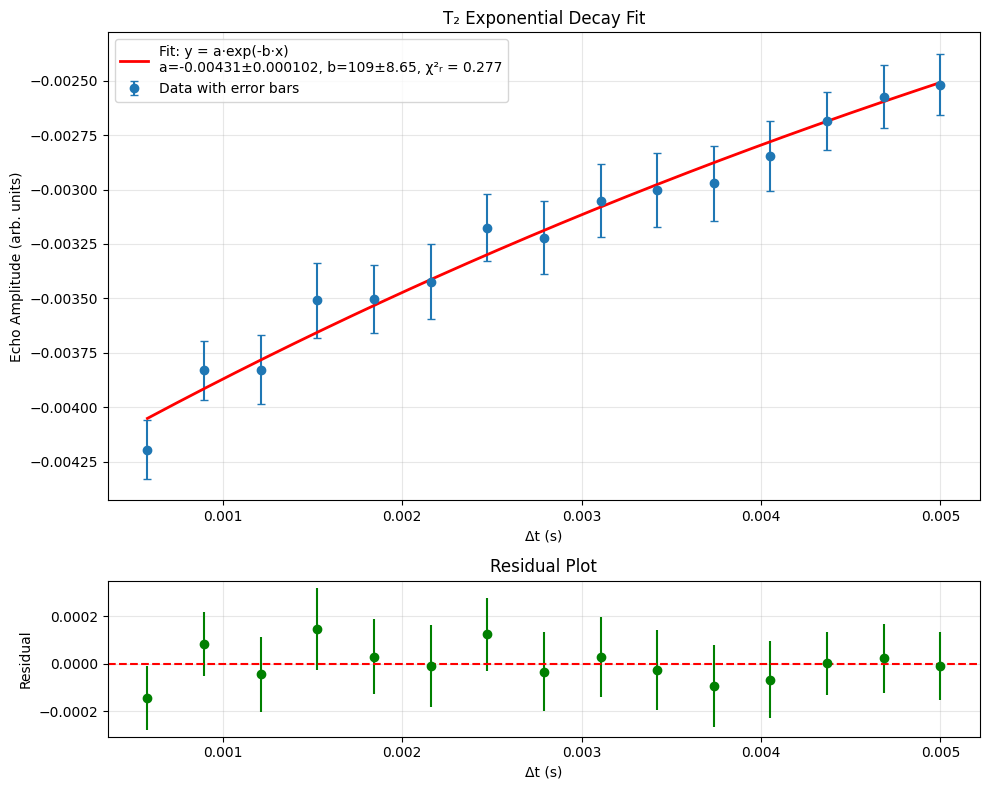


FIT RESULTS:
a = -0.00431494 ± 0.000102075
b = 108.529 ± 8.6493

Reduced χ² = 0.276587


(np.float64(108.52935925397209),
 np.float64(8.649303958412133),
 np.float64(0.2765868803065177))

In [11]:
find_t2(combined_df, plot=True)

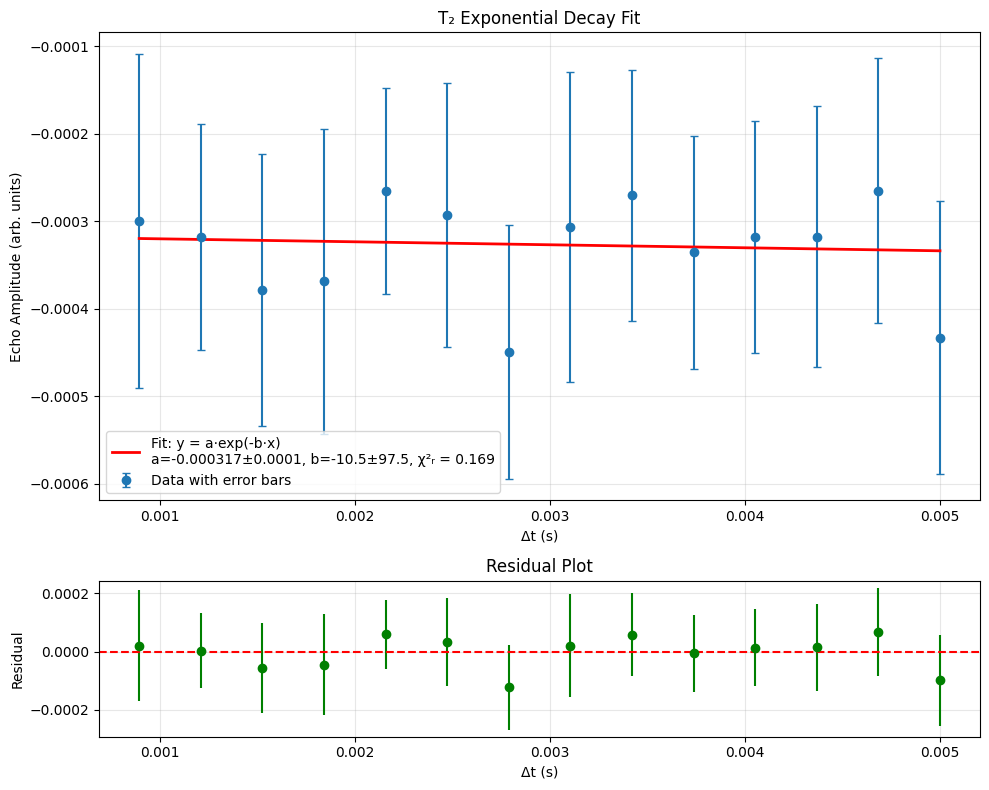


FIT RESULTS:
a = -0.000316675 ± 0.000100452
b = -10.4905 ± 97.5017

Reduced χ² = 0.169414


(np.float64(-10.49045099485818),
 np.float64(97.50167616011333),
 np.float64(0.16941443948793922))

In [13]:
edge_case = pd.read_csv(r'PHY_451_T2_data/FeM2.50e-03.csv')
find_t2(edge_case, plot=True)

In [ ]:
from pathlib import Path
def import_csv_files(file_path, file_beginning):
    """
    Import CSV files matching a pattern with 'M' followed by a numeric value.
    
    Parameters:
    -----------
    file_path : str
        Directory path containing the CSV files
    file_beginning : str
        Beginning pattern of the filename (before the 'M' and numeric value)
    
    Returns:
    --------
    dict
        Dictionary mapping numeric values to pandas DataFrames
        
    Example:
    --------
    # For files like: "data_M1.5e3.csv", "data_M2.0e4.csv"
    result = import_csv_files("/path/to/files", "data_")
    # Returns: {1500.0: df1, 20000.0: df2}
    """
    file_dict = {}
    
    # Create Path object for easier path handling
    path = Path(file_path)
    
    # Check if directory exists
    if not path.exists():
        raise ValueError(f"Directory not found: {file_path}")
    
    # Pattern to match: file_beginning + M + number in scientific notation + .csv
    # This pattern captures numbers like: 1.5e3, 2e4, 3.14e-2, etc.
    pattern = re.compile(
        rf"^{re.escape(file_beginning)}M([\d.]+e[+-]?\d+)\.csv$",
        re.IGNORECASE
    )
    
    # Iterate through files in directory
    for file in path.iterdir():
        if file.is_file():
            match = pattern.match(file.name)
            if match:
                # Extract the numeric value in scientific notation
                numeric_str = match.group(1)
                numeric_value = float(numeric_str)
                
                # Read the CSV file
                try:
                    df = pd.read_csv(file)
                    file_dict[numeric_value] = df
                except Exception as e:
                    print(f"Error reading {file.name}: {e}")
    
    # Sort dictionary by keys for consistent ordering
    file_dict = dict(sorted(file_dict.items()))
    
    if not file_dict:
        print(f"No matching CSV files found in {file_path}")
        print(f"Looking for pattern: {file_beginning}M<number>e<exponent>.csv")
    
    return file_dict

In [ ]:
data_dict = import_csv_files(r"PHY_451_T2_data", "Cu")
cu_fit = []

for m_value, df in data_dict.items():
    t_2, unc, chi_squared = find_t2(df)
    cu_fit.append((m_value, t_2, unc, chi_squared))
    print(f'Cu Concentration: {m_value:.4e} \n\tT_2: {t_2:.4e} \n\tUncertainty: {unc:.4e}\n\t Red chi^2: {chi_squared:.3f}')

data_dict = import_csv_files(r"PHY_451_T2_data", "Fe")
fe_fit = []

for m_value, df in data_dict.items():
    t_2, unc, chi_squared = find_t2(df)
    fe_fit.append((m_value, t_2, unc, chi_squared))
    print(f'Fe Concentration: {m_value:.4e} \n\tT_2: {t_2:.4e} \n\tUncertainty: {unc:.4e}\n\t Red chi^2: {chi_squared:.3f}')

Cu Concentration: 4.8000e-02 
	T_2: 6.1522e+01 
	Uncertainty: 7.5277e+00
	 Red chi^2: 0.152
Cu Concentration: 8.0000e-02 
	T_2: 9.1727e+01 
	Uncertainty: 1.0473e+01
	 Red chi^2: 0.114
Cu Concentration: 1.0000e-01 
	T_2: 1.0853e+02 
	Uncertainty: 8.6493e+00
	 Red chi^2: 0.277
Cu Concentration: 1.6000e-01 
	T_2: 1.7456e+02 
	Uncertainty: 1.2184e+01
	 Red chi^2: 0.165
Cu Concentration: 2.5000e-01 
	T_2: 2.8334e+02 
	Uncertainty: 1.7288e+01
	 Red chi^2: 0.213
Cu Concentration: 3.2000e-01 
	T_2: 4.0711e+02 
	Uncertainty: 1.5396e+01
	 Red chi^2: 1.001
Cu Concentration: 4.8000e-01 
	T_2: 5.7542e+02 
	Uncertainty: 3.2775e+01
	 Red chi^2: 0.259
Cu Concentration: 6.6000e-01 
	T_2: 8.4887e+02 
	Uncertainty: 6.0895e+01
	 Red chi^2: 0.146
Cu Concentration: 7.5000e-01 
	T_2: 4.5123e+02 
	Uncertainty: 4.9179e+01
	 Red chi^2: 21.568
Fe Concentration: 5.0000e-03 
	T_2: 3.8699e+01 
	Uncertainty: 8.2834e+00
	 Red chi^2: 0.408
Fe Concentration: 1.0000e-02 
	T_2: 5.9626e+01 
	Uncertainty: 5.7834e+00
	 Red 

In [ ]:
cu_fit = np.asarray(cu_fit)
fe_fit = np.asarray(fe_fit)

In [ ]:
def weighted_linear_fit(data, element_label="Element"):
    """
    Performs weighted linear regression with uncertainties and plots the result.

    Parameters:
        data (ndarray): Nx4 array with columns [concentration, t2, uncertainty, R2].
        element_label (str): Label for the element (e.g., "Fe", "Cu").
    """

    # Extract data columns
    conc = data[:,0]
    t2 = data[:, 1]
    sigma_t2 = data[:, 2]

    # Weighted least squares setup
    w = 1 / sigma_t2**2
    W = np.sum(w)
    x_bar = np.sum(w * conc) / W
    y_bar = np.sum(w * t2) / W

    # Weighted slope (m) and intercept (c)
    m = np.sum(w * (conc - x_bar) * (t2 - y_bar)) / np.sum(w * (conc - x_bar)**2)
    c = y_bar - m * x_bar

    # Uncertainties (standard errors)
    m_uncert = np.sqrt(1 / np.sum(w * (conc - x_bar)**2))
    c_uncert = np.sqrt(np.sum(w * conc**2) / (W * np.sum(w * (conc - x_bar)**2)))

    # Predicted values and residuals
    y_fit = m * conc + c
    residuals = t2 - y_fit
    chi2 = np.sum(((residuals) / sigma_t2)**2)
    reduced_chi2 = chi2 / (len(conc) - 2)

    # --- Plot ---
    plt.style.use("seaborn-whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))

    # Data points with error bars
    ax.errorbar(conc, t2, yerr=sigma_t2, fmt='o', color='royalblue',
                ecolor='gray', elinewidth=1.2, capsize=3, label='Data (with uncertainty)')

    # Smooth fitted line
    x_fit = np.linspace(np.min(conc), np.max(conc), 200)
    y_fit_smooth = m * x_fit + c
    ax.plot(x_fit, y_fit_smooth, 'r-', lw=2.2, label='Weighted Linear Fit')

    # Annotation box
    fit_text = (
        rf"$T_2 = ({m:.3f} \pm {m_uncert:.3f})x + ({c:.3f} \pm {c_uncert:.3f})$" "\n"
        rf"$\chi^2_{{red}} = {reduced_chi2:.2f}$"
    )
    ax.text(0.98, 0.02, fit_text, transform=ax.transAxes, fontsize=11,
            va='bottom', ha='right',
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#AAAAAA", alpha=0.9))

    # Styling
    ax.set_xlabel("Concentration (mol/L)", fontsize=12)
    ax.set_ylabel(r"$T_2$ (ms)", fontsize=12)
    ax.set_title(f"Weighted Linear Fit for {element_label}", fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # --- Print fit results ---
    print(f"\nWeighted Linear Fit for {element_label}:")
    print(f"  Slope (m) = {m:.6f} ± {m_uncert:.6f}")
    print(f"  Intercept (c) = {c:.6f} ± {c_uncert:.6f}")
    print(f"  Reduced Chi² = {reduced_chi2:.3f}")
    
    return m, m_uncert, c, c_uncert, reduced_chi2

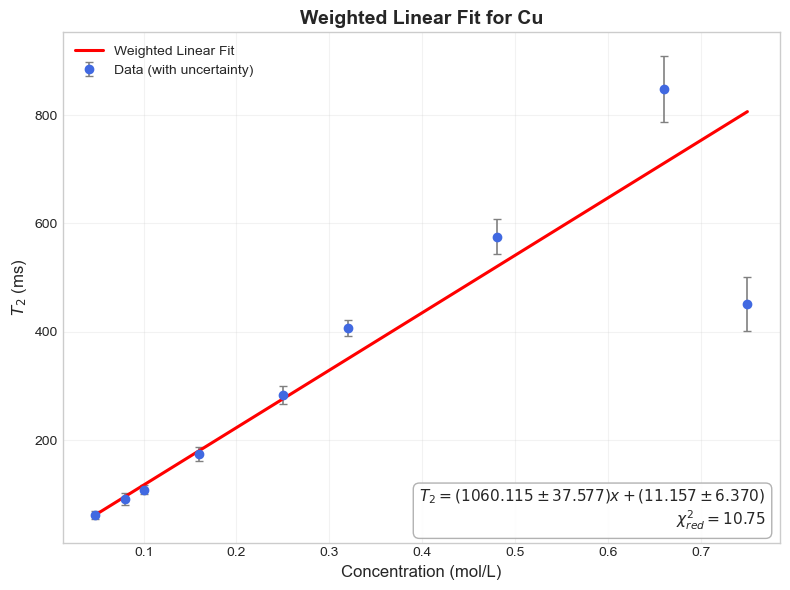


Weighted Linear Fit for Cu:
  Slope (m) = 1060.115021 ± 37.576862
  Intercept (c) = 11.157169 ± 6.370365
  Reduced Chi² = 10.754


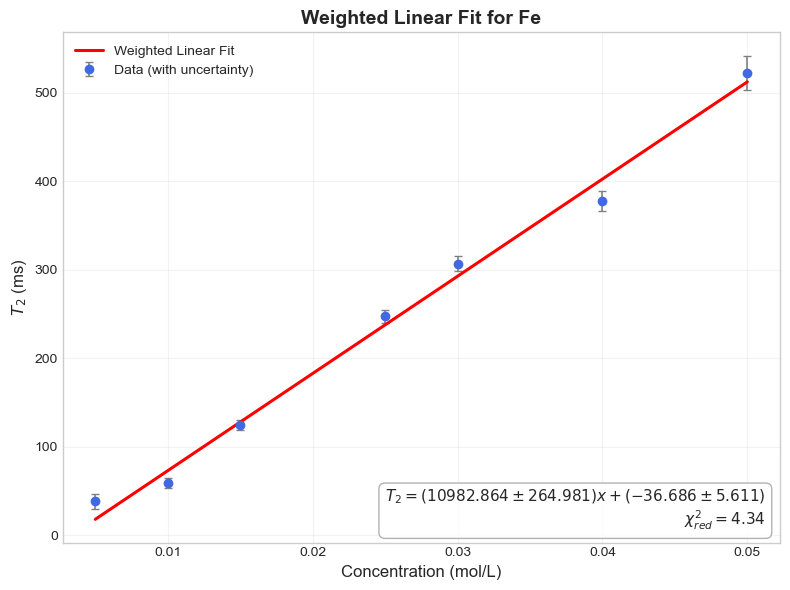


Weighted Linear Fit for Fe:
  Slope (m) = 10982.864207 ± 264.980975
  Intercept (c) = -36.685589 ± 5.611465
  Reduced Chi² = 4.344


In [ ]:
m_cu, m_cu_err, c_cu, c_cu_err, chi2_cu = weighted_linear_fit(cu_fit, element_label="Cu")
m_fe, m_fe_err, c_fe, c_fe_err, chi2_fe = weighted_linear_fit(fe_fit, element_label="Fe")